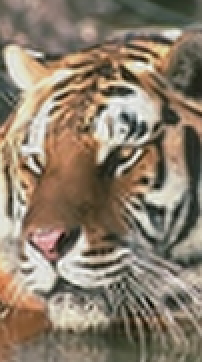

In [51]:
using Images,Distributions, JLD

test_image = "/Users/manvithaponnapati/RAISR/test_data/interpolated/test_image_2.jpg"
test_im = load(test_image)

In [52]:
@everywhere function hashkey(patch,weights_matrix,patchsize)
    gx,gy = imgradients(patch,KernelFactors.ando3)
    gx = reshape(gx,patchsize*patchsize,1)
    gy = reshape(gy,patchsize*patchsize,1)
    GT = transpose([gx gy])
   
    GTWG = GT*weights_matrix*transpose(GT)
    
    eigen_max = eigmax(GTWG)
    eigen_min = eigmin(GTWG)
    eigen_vector_max = eigvecs(GTWG)[:,1]
    eigen_vector_min = eigvecs(GTWG)[:,2]
    gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
    if gradient_angle < 0
        gradient_angle = gradient_angle + pi
    end
    lamda = abs(sqrt(complex(eigen_max)))/Qstrength
    u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
    angle = floor(gradient_angle/pi*Qangle)

    if lamda < 0.0001
        strength = 1
    elseif lamda > 0.001
        strength = 3
    else
        strength = 2
    end

    u = abs(u)
    if u < 0.25
        coherence = 1
    elseif u > 0.5
        coherence = 3
    else
        coherence = 2
    end


    # Bound the output to the desired ranges
    if angle > 23
        angle = 23
    elseif angle <= 0
        angle = 1
    end
    angle = Int(angle)
    return angle,strength,coherence
end

In [53]:
learned_filters = load("learned_filters_59_fullish.jld","filters")

24×3×3×4×25 Array{Float64,5}:
[:, :, 1, 1, 1] =
 1.71556e-5  1.56409e-5  1.59146e-5
 1.60232e-5  1.45188e-5  1.49262e-5
 1.99108e-5  1.62084e-5  1.59829e-5
 1.55394e-5  1.53322e-5  1.57777e-5
 1.54775e-5  1.49677e-5  1.56674e-5
 1.42661e-5  1.4806e-5   1.54572e-5
 2.26622e-5  1.9453e-5   1.7886e-5 
 1.73267e-5  1.80621e-5  1.75717e-5
 1.8299e-5   1.837e-5    1.74416e-5
 1.49376e-5  1.70617e-5  1.71696e-5
 1.69675e-5  2.01639e-5  1.9035e-5 
 1.67393e-5  1.72584e-5  1.68901e-5
 2.41556e-5  2.59907e-5  2.35526e-5
 1.86864e-5  1.84647e-5  1.79951e-5
 1.75089e-5  1.83363e-5  1.7613e-5 
 1.54685e-5  1.77528e-5  1.76459e-5
 2.16557e-5  2.36596e-5  1.77323e-5
 1.74007e-5  1.82377e-5  1.78668e-5
 1.54348e-5  1.53358e-5  1.548e-5  
 1.44869e-5  1.38307e-5  1.55869e-5
 1.85092e-5  1.56879e-5  1.56427e-5
 1.59188e-5  1.53941e-5  1.56608e-5
 1.53009e-5  1.50028e-5  1.52242e-5
 1.4563e-5   1.37524e-5  1.40725e-5

[:, :, 2, 1, 1] =
 2.00992e-5  1.64958e-5  1.72406e-5
 1.28037e-5  1.39998e-5  1.47164e

In [54]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 5
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_59_fullish.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

724×404 Array{Float32,2}:
 0.143047  0.223348  0.223348  0.223348  …  0.225854  0.225854  0.225854
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.221371  0.379998  0.379998  0.379998     0.379829  0.379829  0.379829
 0.221371  0.379998  0.379998  0.379998  …  0.369726  0.369726  0.369726
 0.221371  0.379998  0.379998  0.379998     0.369726  0.369726  0.369726
 0.221371  0.379998  0.379998  0.379998     0.369726  0.369726  0.369726
 0.220364  0.377984  0.377984  0.377984     0.371703  0.371703  0.371703
 0.219357  0.376593  0.376593  0.376593     0.373296  0.373296  0.373296
 0.219357  0.376593  0.376593  0.376593  …  0.373296  0.373296  0.373296
 0.219357  0.376593  0.376593  0.376593     0.373296  0.373296  0.373296
 0.218974  0.375202  0.375202  0.375202     0.37465   0.37465   0.37465 
 ⋮                       

In [55]:
@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-2:row+2,col-2:col+2]
        gradientpatch = ycbcr[1,row-1:row+1,col-1:col+1]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,3)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

 13.946522 seconds (73.61 M allocations: 12.139 GiB, 16.42% gc time)


In [56]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round((upscaledHR[1,:,:] -rmin) * (255 / rmax));
xGR

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Array{Float64,2}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] include_string(::Module, ::String, ::String) at /Users/manvithaponnapati/.julia/v0.6/Compat/src/Compat.jl:174
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/execute_request.jl:154
 [6] eventloop(::ZMQ.Socket) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[56], in expression starting on line 4


724×404 Array{Float64,2}:
 0.0  0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0   85.0   73.0   75.0   75.0      87.0   69.0   71.0  0.0  0.0  0.0
 0.0  0.0   72.0   80.0   82.0   80.0      73.0   74.0   77.0  0.0  0.0  0.0
 0.0  0.0   71.0   82.0   82.0   92.0      72.0   84.0   74.0  0.0  0.0  0.0
 0.0  0.0   90.0   85.0   82.0   93.0  …   72.0   73.0   75.0  0.0  0.0  0.0
 0.0  0.0   91.0   78.0   80.0   79.0      92.0   73.0   75.0  0.0  0.0  0.0
 0.0  0.0   71.0   79.0   79.0   77.0      71.0   72.0   74.0  0.0  0.0  0.0
 0.0  0.0   70.0   77.0   78.0   87.0      71.0   76.0   76.0  0.0  0.0  0.0
 0.0  0.0   70.0   76.0   79.0   85.0      71.0   72.0   79.0  0.0  0.0  0.0
 0.0  0.0   90.0   76.0   78.0   77.0  …   91.0   73.0   75.0  0.0  0.0  0.0
 0.0  0.0   70.0   70.0   71.0   73.0      71.0   79.0   74.0  0.0  0.0  0.0
 0.0  0.0   69.0   75.0   87.0   85.0      71.0   

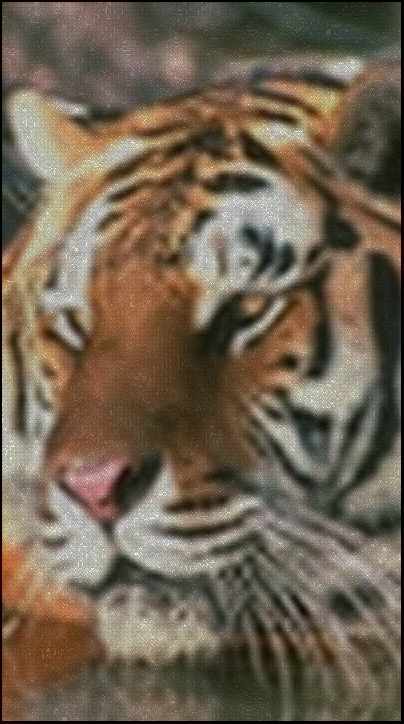

In [57]:
# Download Images from Ec2 Instance - Shut down instance
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])
# load("/Users/manvithaponnapati/RAISR/test_data/test_image_2.jpg")


# Bad performance on very pixelated images

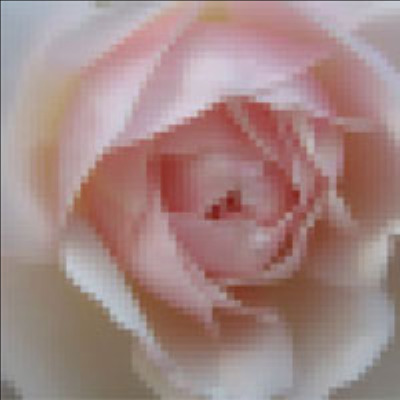

In [58]:
test_image = "/Users/manvithaponnapati/RAISR/test_data/interpolated/pixelrose.jpg"
test_im = load(test_image)

In [59]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 5
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_59_partial.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

800×800 Array{Float32,2}:
 0.0991693  0.13521   0.181354  0.22413   …  0.234655  0.234655  0.234655
 0.13521    0.210658  0.299962  0.385899     0.405941  0.405941  0.405941
 0.181354   0.300969  0.413849  0.526729     0.579683  0.579683  0.579683
 0.225521   0.389303  0.52812   0.665966     0.752838  0.752838  0.752838
 0.215801   0.368857  0.516807  0.663366     0.748847  0.748847  0.748847
 0.208442   0.351778  0.50608   0.662743  …  0.745863  0.745863  0.745863
 0.214794   0.363859  0.513786  0.66472      0.739128  0.739128  0.739128
 0.220523   0.376323  0.522499  0.666074     0.732392  0.732392  0.732392
 0.217155   0.369204  0.515763  0.662706     0.73576   0.73576   0.73576 
 0.213403   0.362084  0.511004  0.658954     0.739128  0.739128  0.739128
 0.210419   0.358716  0.509027  0.659961  …  0.73576   0.73576   0.73576 
 0.208058   0.355348  0.509027  0.662322     0.733399  0.733399  0.733399
 0.212817   0.363859  0.513786  0.666697     0.733015  0.733015  0.733015
 ⋮          

In [60]:
@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-2:row+2,col-2:col+2]
        gradientpatch = ycbcr[1,row-1:row+1,col-1:col+1]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,3)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

 38.538761 seconds (164.58 M allocations: 26.784 GiB, 16.25% gc time)


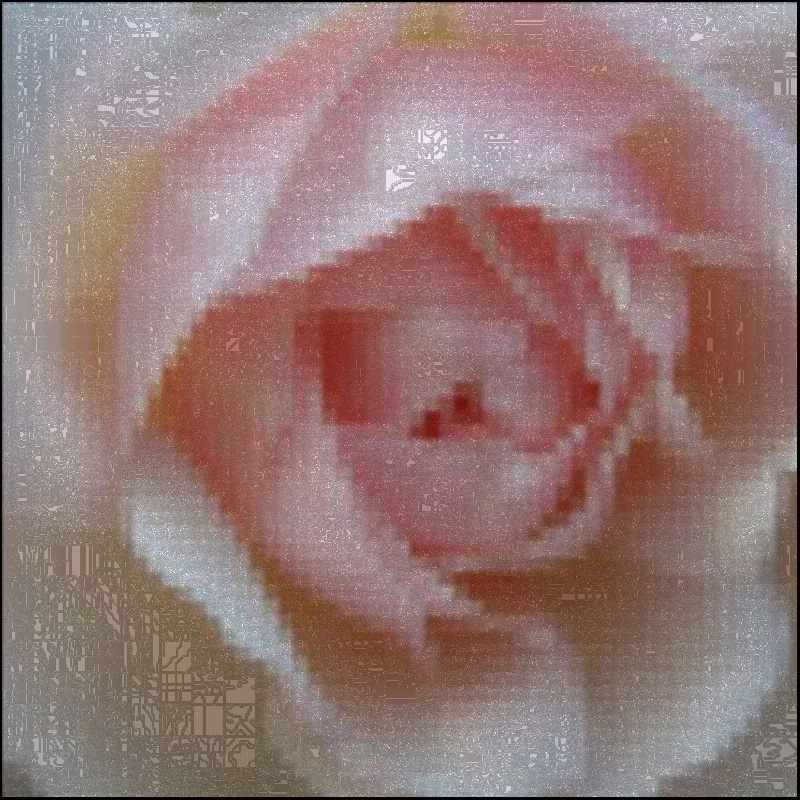

In [61]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round.((upscaledHR[1,:,:] -rmin) * (255 / rmax));
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])